# P4 Scoring Model

## Import des librairies

In [46]:
import seaborn as sns
import pandas as pd 
import os
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from IPython.display import display, HTML

# numpy and pandas for data manipulation


In [47]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)

pandas version: 2.2.3
numpy version: 2.1.1
seaborn version: 0.13.2


In [103]:
def display_info(title = "",tag="h3",message="Params allowed: title,tag,message,color", color="white"):
    if (title!=""):
        display(HTML(f"""
        <{tag} style='color:{color}'>{title}</{tag}>
        <p style='color:{color}'>{message}</p>"""))
    else:
        display(HTML(f"""
        <p style='color:{color}'>{message}</p>"""))

## Importation des données

Les données sont réparties dans les fichiers ci-dessous:

In [49]:
display_info(title="",tag="p",message="Voici la liste des différents fichiers disponibles :",color="green")
print(os.listdir("../datas"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


et lié selon le graphique suivant:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

**application_{train|test}.csv** <br>
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

**bureau.csv**<br>
Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

**bureau_balance.csv**<br>
Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois où nous avons un historique observable pour les crédits précédents) lignes.

**POS_CASH_balance.csv**<br>
Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

**credit_card_balance.csv**<br>
Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de cartes de crédit précédentes relatives * nombre de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

**previous_application.csv**<br>
Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

**installments_payments.csv**<br>
Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

**HomeCredit_columns_description.csv**<br>
Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [56]:
app_train = pd.read_csv('../datas/application_train.csv')
app_test = pd.read_csv('../datas/application_test.csv')
bureau = pd.read_csv('../datas/bureau.csv')
bureau_balance = pd.read_csv('../datas/bureau_balance.csv')
pos_CASH_balance = pd.read_csv('../datas/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('../datas/credit_card_balance.csv')
previous_application = pd.read_csv('../datas/previous_application.csv')
installments_payments = pd.read_csv('../datas/installments_payments.csv')
columns_description = pd.read_csv('../datas/HomeCredit_columns_description.csv', sep=';', encoding="unicode_escape")

In [60]:
# Liste des datasets et titres
datasets = [app_train,app_test, bureau, bureau_balance, pos_CASH_balance, credit_card_balance,
            previous_application, installments_payments, columns_description]

titles = ["app_train","app_test", "bureau", "bureau_balance", "pos_CASH_balance", "credit_card_balance",
          "previous_application", "installments_payments", "columns_description"]

# Création du DataFrame avec les infos
info_df = pd.DataFrame({},)
info_df['Dataset'] = titles

info_df["nbrs_of_columns"] = [len(df.columns) for df in datasets]

# Remplacement des virgules par des sauts de ligne
info_df["columns_name"] = [', '.join(list(df.columns)) for df in datasets]

info_df['nbrs_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='rocket')


,Dataset,nbrs_of_columns,columns_name,nbrs_of_rows
0,app_train,122,"SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",307511
1,app_test,121,"SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPRE

### Description des variables

## La Cible à prédire: Le client est-il en difficulté de paiement?

In [66]:
app_train_duplicated= app_train.duplicated(subset=['SK_ID_CURR']).sum()
display_info(title='',tag='',message=f'Nombre de prêts unique dupliqués : {app_train_duplicated}')

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_26823/1148136057.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([loan_map.get(int(item.get_text()),item.get_text()) for item in ax.get_xticklabels()])


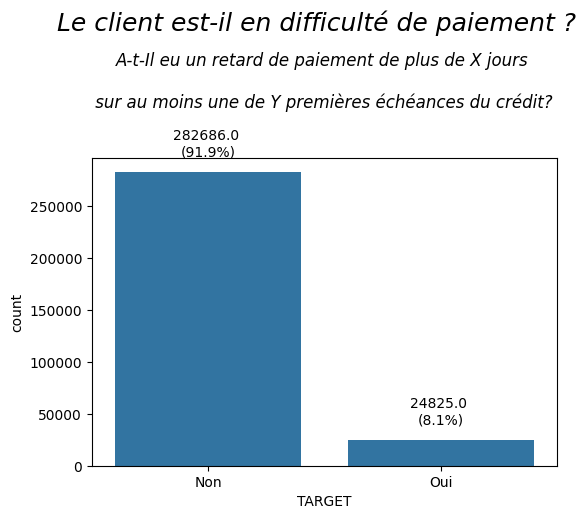

In [184]:
fig,ax = plt.subplots(figsize=(6,4))
loan_map = {
    1: "Oui",
    0: "Non",
}
sns.countplot(data=app_train,x='TARGET', ax=ax)
ax.set_xticklabels([loan_map.get(int(item.get_text()),item.get_text()) for item in ax.get_xticklabels()])

total = len(app_train)  # Total des valeurs
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{height} \n({percentage:.1f}%)\n', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center')
    
plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.25,fontsize=18, fontstyle='italic')
plt.title("A-t-Il eu un retard de paiement de plus de X jours \n\n sur au moins une de Y premières échéances du crédit? \n\n",
          loc="center",fontsize=12, fontstyle='italic')
plt.show()

In [106]:
display_info(title="Les clients en difficulté de paiement sont largement sous-représentés (8.1%) dans les données d'entraînement",message="Il s'agit d'un déséquilibre de classe.")
display_info(message=
             "Les méthodes de machine learning classiques ne sont pas toujours adaptées pour la classification sur des données déséquilibrées. Elles donnent souvent de mauvais résultats et, pire encore, elles peuvent induire en erreur avec des scores trop optimistes.</br>Une des causes de ces échecs est que les points de la classe minoritaire sont considérés comme des outliers qui ne contiennent aucune information.")

## Data Cleaning ensembles d'entraînement

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_26823/233768322.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentage.index,rotation=90, fontsize=8)


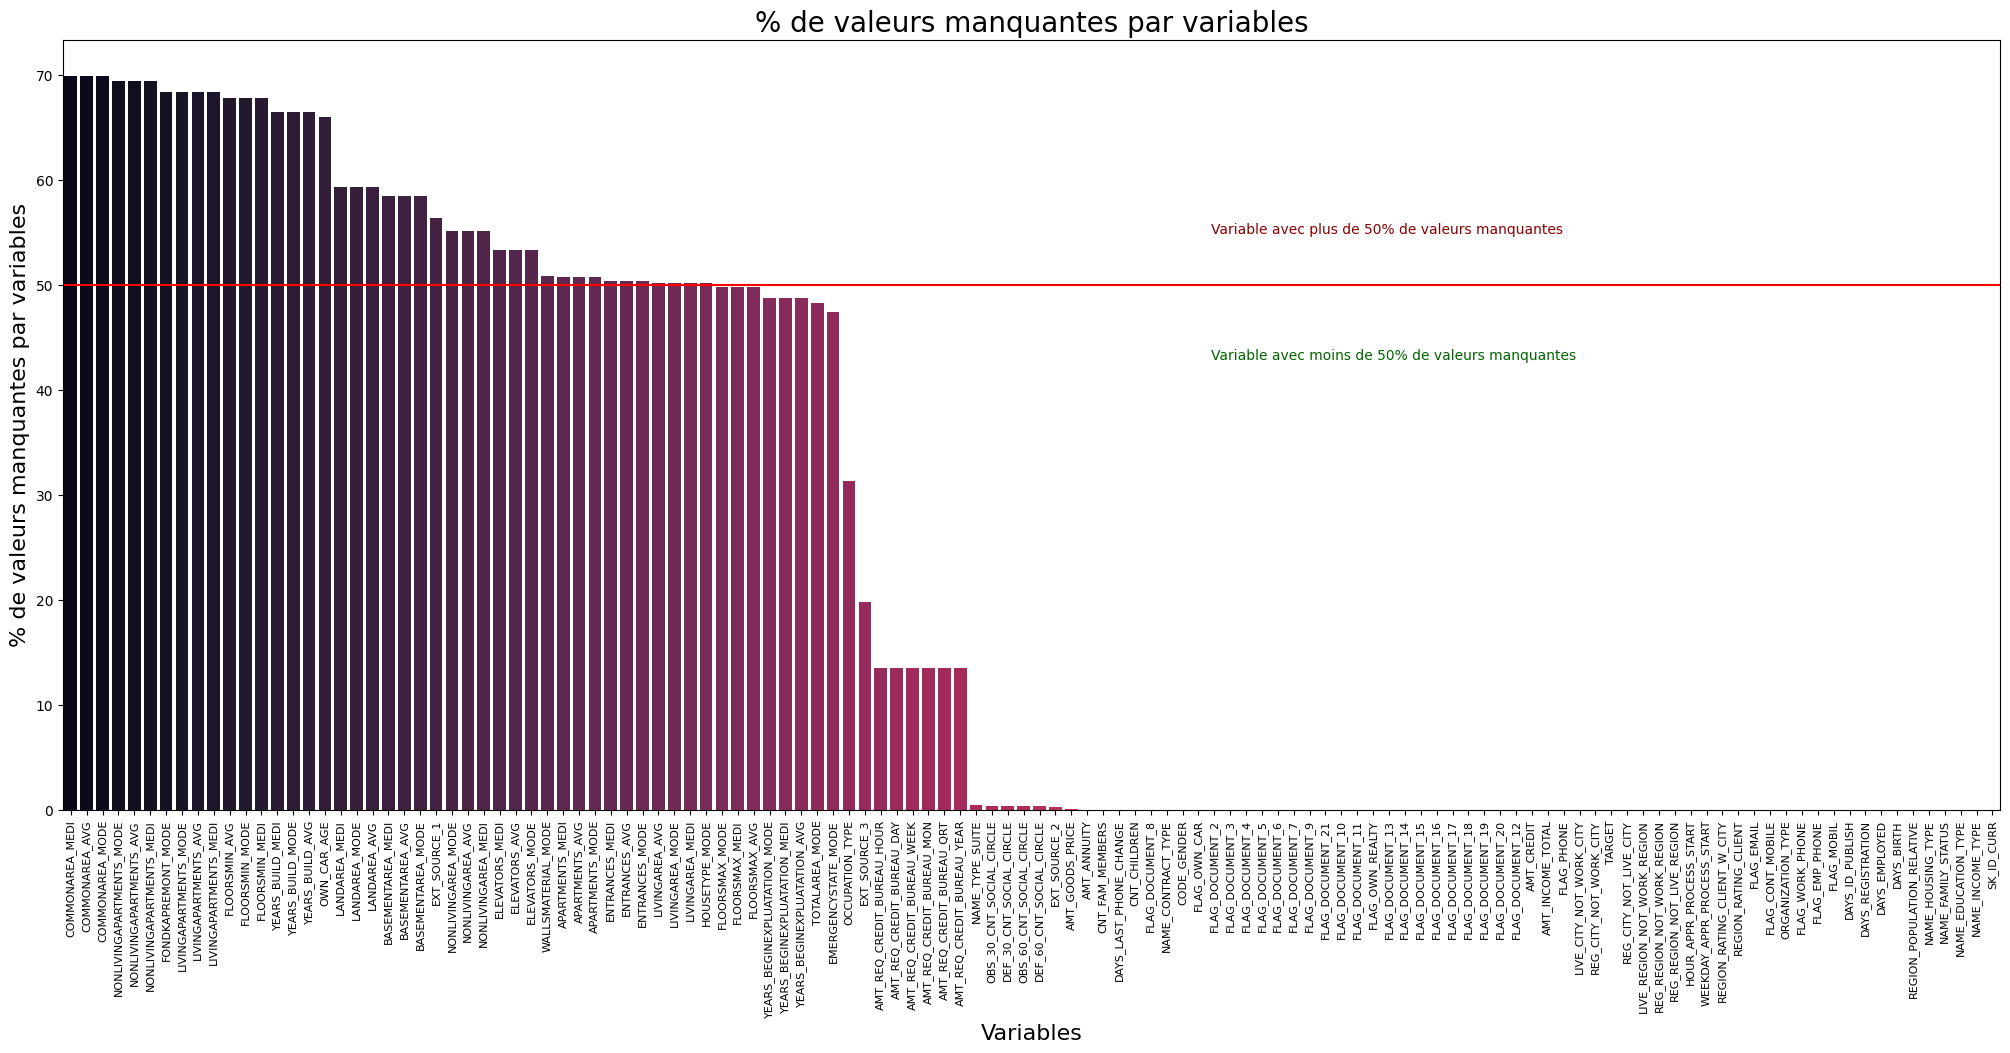

In [177]:
app_train_missingNum = app_train.select_dtypes(include=['int','float64'])

treshold_null = 50
fig,ax = plt.subplots(1,1,figsize=(25,10))
percentage = (app_train.isnull().sum()*100)/app_train.shape[0]
percentage=percentage.sort_values(ascending=False)

ax = sns.barplot(x=app_train.columns, y=percentage,palette="rocket", ax=ax, hue=app_train.columns)

plt.axhline(y=treshold_null,color='r', linestyle ='-')

plt.text(len(app_train.isnull().sum()/len(app_train))/1.7,treshold_null+6,f"Variable avec plus de {treshold_null}% de valeurs manquantes", ha='left',va='top', color='darkred')
plt.text(len(app_train.isnull().sum()/len(app_train))/1.7,treshold_null-6,f"Variable avec moins de {treshold_null}% de valeurs manquantes", ha='left',va='top', color='darkgreen')

ax.set_title("% de valeurs manquantes par variables",fontsize=20)
ax.set_ylabel("% de valeurs manquantes par variables", fontsize=16)
ax.set_xlabel("Variables",fontsize=16)
ax.set_xticklabels(percentage.index,rotation=90, fontsize=8)
plt.show()

In [193]:
app_train_missingNum.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


**Le describe nous permet d'avoir une vue rapide des valeurs de chaque variable**</br>
</br>
On remarque que <b>DAYS_EMPLOYED</b> contient des valeurs impossibles. Les valeurs sont relative à la date de l'application. Il ne peut donc pas y avoir de valeur positive.

In [215]:
app_train_missingNum[app_train_missingNum["DAYS_EMPLOYED"] <= 0]["DAYS_EMPLOYED"].value_counts().sum()

np.int64(252137)

In [211]:
app_train_missingNum[app_train_missingNum["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"].value_counts().sum()

np.int64(55374)

In [205]:
app_train_missingNum["DAYS_EMPLOYED"].value_counts().sum()

np.int64(307511)

In [206]:
app_train_missingNum["DAYS_EMPLOYED"].isna().sum()

np.int64(0)

In [207]:
app_train_missingNum["DAYS_EMPLOYED"].unique()

array([  -637,  -1188,   -225, ..., -12971, -11084,  -8694])

In [208]:
app_train_missingNum["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: count, Length: 12574, dtype: int64

In [209]:
app_train_filtered = app_train_missingNum[app_train_missingNum["DAYS_EMPLOYED"] != 365243]

In [210]:
app_train_filtered.shape

(252137, 106)